# 🧠 CIFAR-10 Image Classification with PyTorch

Welcome to the **CIFAR-10 image classification** project! 🎉

In this project, we'll build, train, and evaluate convolutional neural networks (CNNs) using **PyTorch** on the **CIFAR-10 dataset**, which consists of 60,000 color images across 10 different classes:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

We'll explore:
- Building a Simple NN 
- Building a CNN 
- Evaluating model's performance
- Visualizing training progress
- Improving results with regularization
- (Optional) Transfer learning with pretrained models

Let's get started! 🚀


## 0. Importing Libraries


In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# For visualisation 
import matplotlib.pyplot as plt

# For progress bar
from tqdm.auto import tqdm 

# To visualize timings of the models
from timeit import default_timer as timer

## 1. Getting a dataset 
The dataset we'll be using CIFAR10 From `torchvision.datasets`

In [4]:
# Setup training data 
train_data = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(), # To convert the images into tensor
    target_transform=None # How do we want to transform the labels/ targets?
)

test_data = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
    
)

100%|████████████████████████████████████████████████████████████████████████████████| 170M/170M [04:25<00:00, 642kB/s]


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
len(train_data), len(test_data)

(50000, 10000)

In [6]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [7]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [11]:
train_data.targets[:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

### 1.1 Check input and output shapes of data 


In [13]:
# Check the shape of our image
print(f'Image Shape: {image.shape} -> [color_channel, height, width]')
print(f'Image Label: {class_names[label]}')

Image Shape: torch.Size([3, 32, 32]) -> [color_channel, height, width]
Image Label: frog


### 1.2 Visualizing our data 

Image Shape: torch.Size([3, 32, 32])


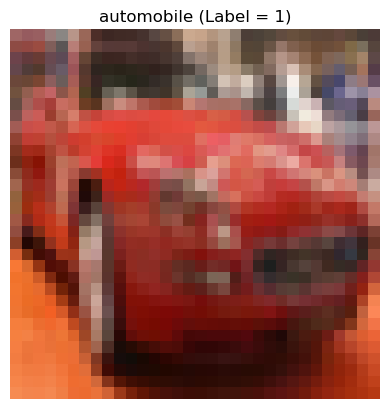

In [26]:
import matplotlib.pyplot as plt

# Sample one image and its label from the dataset
image, label = train_data[5]

print(f'Image Shape: {image.shape}')  # Should print: torch.Size([3, 32, 32])

# Plot the image (permute to move channels to the end)
plt.imshow(image.permute(1, 2, 0), interpolation='nearest')  # [3, 32, 32] → [32, 32, 3]
plt.title(f'{class_names[label]} (Label = {label})')
plt.axis('off')
plt.show()


The images looks too blury but that's okay hope our network will still be able to find patterns in this data.
They are blurry because the size is very small [3, 32, 32].

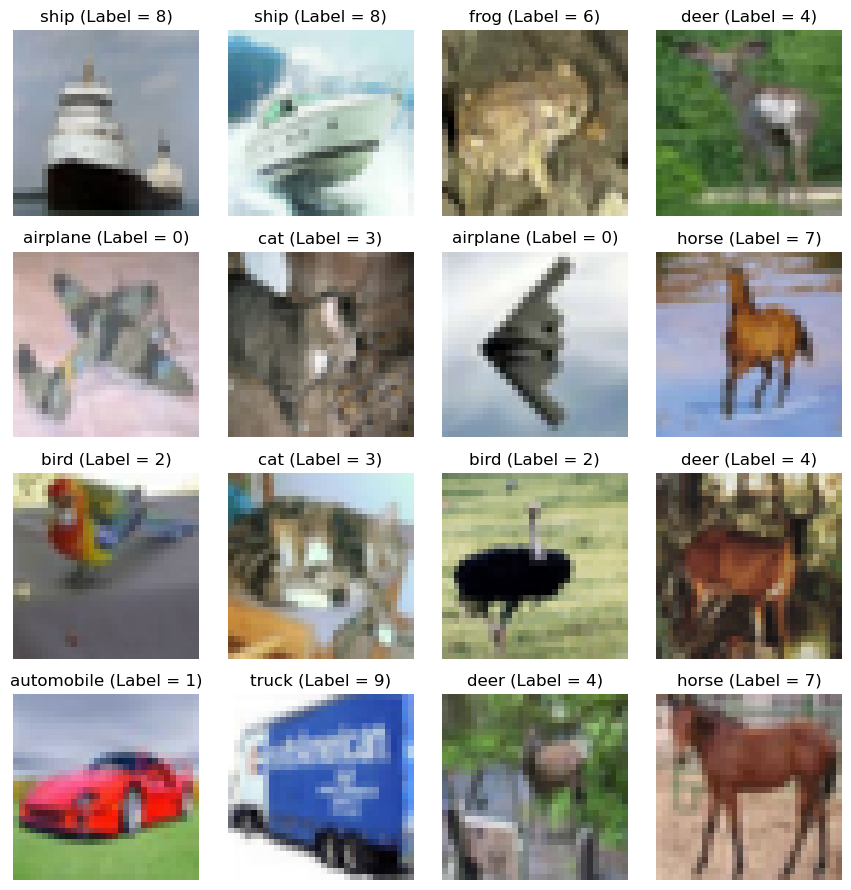

In [30]:
# Plot random images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0), interpolation='nearest')
    plt.title(f'{class_names[label]} (Label = {label})')
    plt.axis('off')
    plt.tight_layout()

Images are clear at some extent Hope it will work better in case of Neural Networks.

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this ? 

* It is more computationally efficient, as in our compuing hardware may not be able to look (store in memory) at 50,000 images in one hit. so we break it down to 16 or 32 or 2**N image at time (batch size of 32 or 64 or 128 etc..)
* It gives our neural network more chances to update it's gradient per epoch for example if we have 100 total batches so in 1 epoch the gradient descent will take 100 updates in just 1 epoch.

In [31]:
from torch.utils.data import DataLoader

# Setup the batchsize hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2009c34d240>,
 <torch.utils.data.dataloader.DataLoader at 0x2009f753070>)

In [34]:
# Let's check out how many batches are there in each dataloader
print(f'Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')

Length of train_dataloader: 1563 batches of 32
Length of test_dataloader: 313 batches of 32


In [35]:
50000/32

1562.5

In [36]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

Image size: torch.Size([3, 32, 32])
Label: 6, label size: torch.Size([])


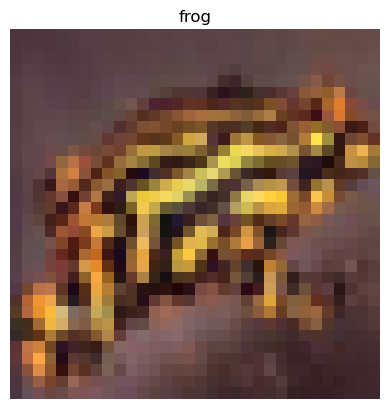

In [37]:
# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')
print(f'Image size: {img.shape}')
print(f'Label: {label}, label size: {label.shape}')

### 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [88]:
class CIFAR10ModelV0(nn.Module):
    """
    A baseline fully-connected neural network model for CIFAR-10 classification.

    This model flattens the 3x32x32 input image and passes it through a single hidden layer,
    followed by an output layer that maps to the 10 CIFAR-10 classes.

    Note:
        - This model does NOT use any convolutional layers.
        - It's intended as a simple baseline for comparison.

    Args:
        input_shape (int): Flattened input size (e.g., 3*32*32 = 3072 for CIFAR-10).
        hidden_units (int): Number of units in the hidden fully-connected layer.
        output_shape (int): Number of output classes (e.g., 10 for CIFAR-10).
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super(CIFAR10ModelV0, self).__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),  # Flatten 3D input to 1D vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, 32, 32).

        Returns:
            torch.Tensor: Output logits tensor of shape (batch_size, output_shape).
        """
        return self.layer_stack(x)

In [89]:
torch.manual_seed(42)

# Setup model with input params
model_0 = CIFAR10ModelV0(
    input_shape=3*32*32,
    hidden_units=10,
    output_shape=len(class_names)
)
# we are using device cpu for now this is very simple model
model_0.to('cpu')

CIFAR10ModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

The best way to understand what's going on in the model pass random data of same shape to understand the results of the model (logits.)

In [90]:
dummy_x = torch.rand([1, 3, 32, 32])
model_0(dummy_x) # 10 logits

tensor([[ 0.2860,  0.0425,  0.1333, -0.3589, -0.0223,  0.0192,  0.1143, -0.0072,
         -0.1990, -0.1155]], grad_fn=<AddmmBackward0>)

It returns the raw logits for each class (10)

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntorpyLoss()`
* Opimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric.

In [91]:
#Let's pick a loss function and optimizer and accuracy metric
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
* Model's Performance (loss, accuracy, etc...)
* How fast it runs...

In [92]:
def print_train_time(start: float,
                    end: float,
                    device: torch.device = None):
    '''Prints difference between start and end time.'''
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

### 3.3 Creating a training loop and training a model on batches of data

In [93]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [94]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time and more experimentation)
epochs = 5

# Creating training and testing loop
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n......')
    # Training
    train_loss = 0
    train_acc = 0
    # Add a loop to through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        # 1. Forward pass 
        y_pred = model_0(X)

        # 2. Calc loss and accuracy per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # 3. Optimizer zero grad 
        optimizer.zero_grad()

        # 4. backpropogation
        loss.backward()

        # 5. Gradient Descent
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 200 == 0:
            print(f'Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples')

    # Divide total train loss and acc by length of train dataloader(average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracies)

    # Testing 
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass 
            test_pred = model_0(X)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y)

            # 3. calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Divide total test loss by length of test dataloader
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    # Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

            
# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device=str(next(model_0.parameters()).device)
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
......
Looked at 0 / 50000 samples
Looked at 6400 / 50000 samples
Looked at 12800 / 50000 samples
Looked at 19200 / 50000 samples
Looked at 25600 / 50000 samples
Looked at 32000 / 50000 samples
Looked at 38400 / 50000 samples
Looked at 44800 / 50000 samples

Train loss: 1.94554 | Train acc: 30.53% | Test loss: 1.86720, Test acc: 33.45%

Epoch: 1
......
Looked at 0 / 50000 samples
Looked at 6400 / 50000 samples
Looked at 12800 / 50000 samples
Looked at 19200 / 50000 samples
Looked at 25600 / 50000 samples
Looked at 32000 / 50000 samples
Looked at 38400 / 50000 samples
Looked at 44800 / 50000 samples

Train loss: 1.82660 | Train acc: 35.56% | Test loss: 1.81328, Test acc: 36.59%

Epoch: 2
......
Looked at 0 / 50000 samples
Looked at 6400 / 50000 samples
Looked at 12800 / 50000 samples
Looked at 19200 / 50000 samples
Looked at 25600 / 50000 samples
Looked at 32000 / 50000 samples
Looked at 38400 / 50000 samples
Looked at 44800 / 50000 samples

Train loss: 1.79270 | Train acc: 37.

## 4. Make predictions and get Model 0 results

In [95]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        'model_name': model.__class__.__name__,
        'model_loss': loss.item(),
        'model_acc': acc
    }

model_0_results = eval_model(model=model_0,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [96]:
model_0_results

{'model_name': 'CIFAR10ModelV0',
 'model_loss': 1.8486546277999878,
 'model_acc': 35.1138178913738}

### 📊 Baseline Model Performance — `CIFAR10ModelV0`

Our baseline fully-connected model (`CIFAR10ModelV0`) achieved the following results on the CIFAR-10 test set:

- **Loss:** 1.84 
- **Accuracy:** 35.11%

This sets a simple benchmark for comparison with more advanced models (e.g., CNNs) in upcoming experiments.


## 5. Setup device agnostic-code (for using GPU if there is one if not it works fine.)

In [97]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 6. Model 1: Building a better model with non-linearity


In [103]:
# Create a model with non-linear and linear layers
# Set random seed for reproducibility
torch.manual_seed(42)

class CIFAR10ModelV1(nn.Module):
    """
    A fully-connected neural network with non-linear activation functions (ReLU) for CIFAR-10 classification.

    Compared to the baseline (Model V0), this model introduces ReLU activations after each linear layer,
    allowing it to learn more complex, non-linear relationships in the data.

    Note:
        - Input images are flattened before being passed through the linear layers.
        - This is still not a convolutional model, but improves expressiveness over the baseline.

    Args:
        input_shape (int): Flattened input size (e.g., 3*32*32 = 3072 for CIFAR-10).
        hidden_units (int): Number of units in the hidden layer.
        output_shape (int): Number of output classes (e.g., 10 for CIFAR-10).
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super(CIFAR10ModelV1, self).__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),  # Convert 3D image to 1D vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),  # Non-linearity after hidden layer
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()   # Optional non-linearity at output (can be removed before softmax/logits)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, 32, 32).

        Returns:
            torch.Tensor: Output logits tensor of shape (batch_size, output_shape).
        """
        return self.layer_stack(x)


In [104]:
model_1 = CIFAR10ModelV1(input_shape=3*32*32,
                        hidden_units=10,
                        output_shape=len(class_names)).to(device)
model_1

CIFAR10ModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

### 6.1 Setup loss, optimizer and evaluation metrics

In [105]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)


### 6.2 Functionizing training and evaluation/testing loops

Let's create a function for:

* training loop - train_step()
* testing_loop - test_step()

In [106]:

def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):

    """Performs a training step with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0

    # Put model into training mode
    model.train() 
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):

        # Put data on target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Divide total train loss  and acc by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f'Train Loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%')
    

def test_step(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device = device):
    """Performs a testing loop step on model going over data_loader"""

    test_loss, test_acc = 0, 0
    # Put the model in eval mode
    model.eval()

    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send the data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        # Adjust metrics and print out

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n')
            

In [107]:
torch.manual_seed(42)

# Measure time 
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 5

# Create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(model=model_1, 
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 2.05379 | Train acc: 27.54%
Test loss: 1.97437 | Test acc: 31.36%

Epoch: 1
--------
Train Loss: 1.91921 | Train acc: 33.81%
Test loss: 1.91148 | Test acc: 33.70%

Epoch: 2
--------
Train Loss: 1.87799 | Train acc: 35.51%
Test loss: 1.90338 | Test acc: 33.89%

Epoch: 3
--------
Train Loss: 1.85471 | Train acc: 36.23%
Test loss: 1.88788 | Test acc: 34.40%

Epoch: 4
--------
Train Loss: 1.84040 | Train acc: 36.86%
Test loss: 1.87328 | Test acc: 36.37%

Train time on cuda: 65.512 seconds


In [108]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
    """Returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {'model_name': model.__class__.__name__, # only works when model was created with a class
           'model_loss': loss.item(),
           'model_acc': acc}


In [109]:
# Get model_1 results dictionary
# Calculate model 1 results on data dataset 
model_1_results = eval_model(model=model_1,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CIFAR10ModelV1',
 'model_loss': 1.8732761144638062,
 'model_acc': 36.37180511182109}

### 📊 Model V1 Performance — `CIFAR10ModelV1`

Our second model (`CIFAR10ModelV1`) added ReLU activation functions to introduce non-linearity and improve the model’s expressiveness over the baseline.

**Evaluation Results:**
- **Loss:** 1.87  
- **Accuracy:** 36.37%

Despite the added non-linearities, this model performed slightly better compared to the baseline. This suggests that flattening the image may still be limiting the model's ability to extract spatial features — motivating the need for convolutional layers in the next version.


## 7. Model 2: Building a Convolutional Neural Network(CNN)

CNN's are known for their capabilities to find patterns in visual data.

In [115]:
# Create a convolutional neural network
class CIFAR10ModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
        )
        self.classfier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8,
                     out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classfier(x)
        #print(x.shape)
        return x

In [116]:
torch.manual_seed(42)
model_2 = CIFAR10ModelV2(input_shape=3,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)


In [117]:
# Let's pass random tensor to the model
rand_image_tensor = torch.randn(size=[1, 3, 32, 32])
rand_image_tensor.shape

torch.Size([1, 3, 32, 32])

In [118]:
# Pass random image through model
model_2(rand_image_tensor.to(device))

tensor([[-0.0632, -0.0633, -0.0042, -0.0175,  0.0455, -0.0195, -0.0302, -0.0788,
          0.0230, -0.0267]], device='cuda:0', grad_fn=<AddmmBackward0>)

Wow we get 10 raw logits that's great

### 7.1 Setup a loss function and optimizer for model_2

In [119]:
# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), 
                            lr=0.1)

### 7.2 Training and Testing

In [120]:
torch.manual_seed(42)

# Measure time 
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 5

# Create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(model=model_2, 
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_2,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 2.17119 | Train acc: 18.50%
Test loss: 1.84392 | Test acc: 32.15%

Epoch: 1
--------
Train Loss: 1.64213 | Train acc: 41.22%
Test loss: 1.55511 | Test acc: 44.53%

Epoch: 2
--------
Train Loss: 1.39620 | Train acc: 50.32%
Test loss: 1.40668 | Test acc: 50.39%

Epoch: 3
--------
Train Loss: 1.30424 | Train acc: 53.85%
Test loss: 1.34167 | Test acc: 52.47%

Epoch: 4
--------
Train Loss: 1.25222 | Train acc: 56.04%
Test loss: 1.23310 | Test acc: 56.23%

Train time on cuda: 74.236 seconds


In [121]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CIFAR10ModelV2',
 'model_loss': 1.2331024408340454,
 'model_acc': 56.23003194888179}

In [122]:
model_0_results, model_1_results, model_2_results

({'model_name': 'CIFAR10ModelV0',
  'model_loss': 1.8486546277999878,
  'model_acc': 35.1138178913738},
 {'model_name': 'CIFAR10ModelV1',
  'model_loss': 1.8732761144638062,
  'model_acc': 36.37180511182109},
 {'model_name': 'CIFAR10ModelV2',
  'model_loss': 1.2331024408340454,
  'model_acc': 56.23003194888179})

## 8. Compare model results and training time

In [123]:
import pandas as pd 
compare_results = pd.DataFrame([model_0_results,
                               model_1_results,
                               model_2_results])
compare_results

,model_name,model_loss,model_acc
0,CIFAR10ModelV0,1.848655,35.113818
1,CIFAR10ModelV1,1.873276,36.371805
2,CIFAR10ModelV2,1.233102,56.230032


In [124]:
# Add training time to results comparision
compare_results['training_time'] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,CIFAR10ModelV0,1.848655,35.113818,48.778751
1,CIFAR10ModelV1,1.873276,36.371805,65.512089
2,CIFAR10ModelV2,1.233102,56.230032,74.235607


Text(0, 0.5, 'model')

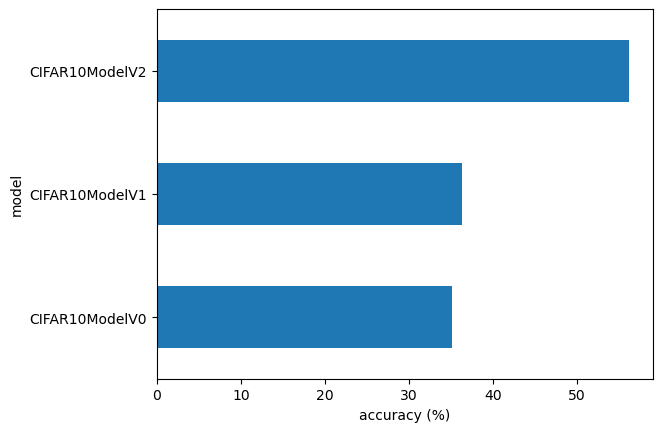

In [125]:
# Visualize our model results
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy (%)')
plt.ylabel('model')

### 📊 Model Comparison Summary

We trained and evaluated three models of increasing complexity on the CIFAR-10 dataset:

| Model            | Loss   | Accuracy (%) |
|------------------|--------|--------------|
| `CIFAR10ModelV0` | 1.85   | 35.11        |
| `CIFAR10ModelV1` | 1.87   | 36.37        |
| `CIFAR10ModelV2` (TinyVGG) | **1.23** | **56.23**      |

#### 🔍 Observations:
- **Model V0** (baseline fully-connected network) set a basic performance benchmark.
- **Model V1** introduced non-linearities with ReLU but did not significantly improve accuracy, indicating that flattening the image early discards important spatial information.
- **Model V2** (TinyVGG) made a **substantial performance leap**, thanks to convolutional layers that preserve and learn spatial features in the input images.

This clearly demonstrates the power of CNNs in image classification tasks and sets the stage for further improvements such as data augmentation, regularization, or transfer learning.


## 9. Make and evaluate random predictions with best model

In [126]:
def make_predictions(model: torch.nn.Module,
                    data: list,
                    device: torch.device=device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logits = model(sample)

            # Get prediction probability (logit -> pred prob)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            # Get pred_prob off the GPU for further calculation
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)



In [127]:
import random 
#random.seed(422)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first  sample shape
test_samples[0].shape

torch.Size([3, 32, 32])

Text(0.5, 1.0, 'cat')

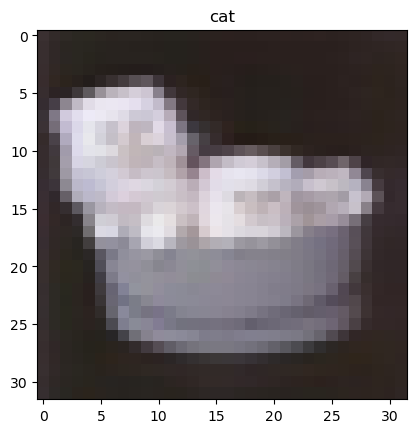

In [129]:
plt.imshow(test_samples[0].permute(1, 2, 0))
plt.title(class_names[test_labels[0]])

In [130]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probs.
pred_probs[:2]

tensor([[1.7664e-02, 7.1824e-02, 9.6436e-03, 1.2006e-01, 4.8951e-03, 1.0474e-01,
         1.2575e-02, 7.7243e-02, 4.6020e-01, 1.2116e-01],
        [4.1000e-03, 9.0581e-01, 2.8178e-04, 3.5630e-04, 1.4408e-04, 2.8018e-04,
         3.4824e-04, 1.5261e-04, 1.1125e-02, 7.7405e-02]])

In [131]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 1, 2, 6, 8, 2, 9, 4, 6])

In [132]:
test_labels

[3, 1, 2, 3, 8, 5, 9, 3, 4]

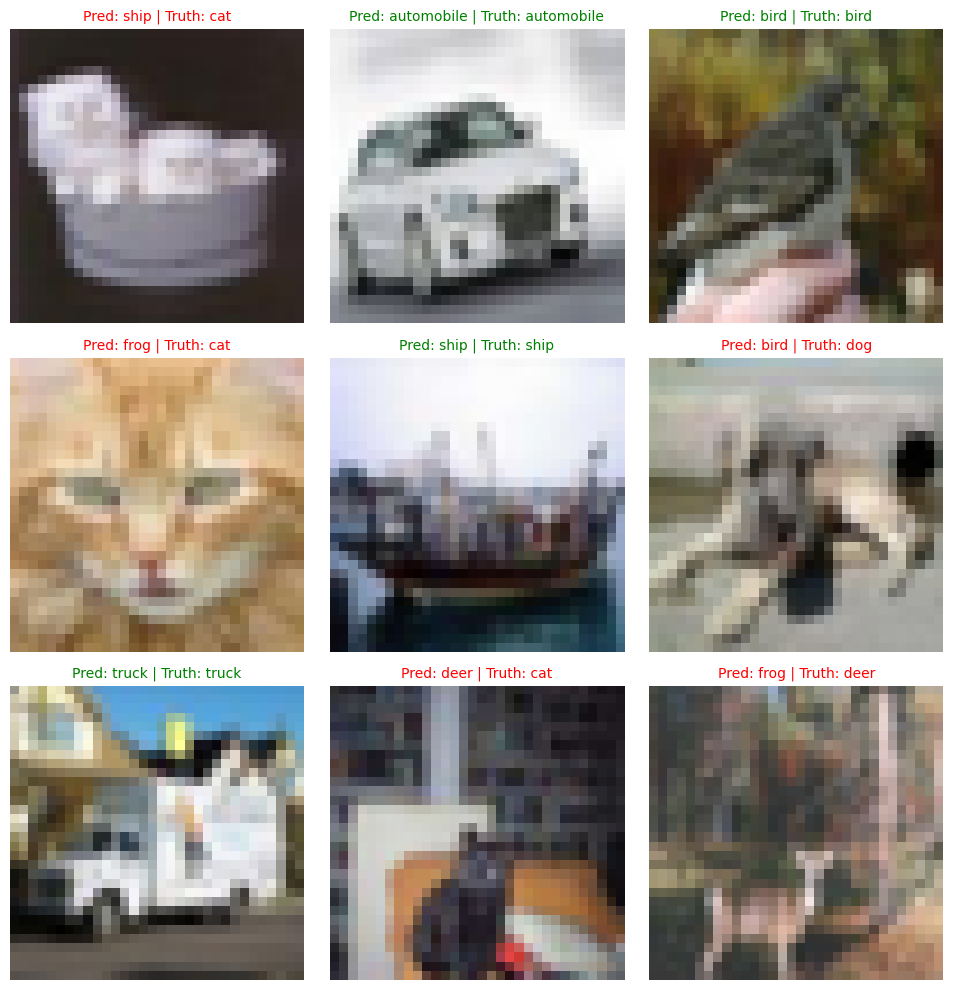

In [133]:
# Plot the predictions
plt.figure(figsize=(10, 10))
nrows = 3
ncols = 3 
for i, sample in enumerate(test_samples):
    # Create suplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0))

    # Find the prediction (in text form eg. Sandal)
    pred_label = class_names[pred_classes[i]]

    # Find the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'

    # Check for equality b/w pred and truth and change color of title text 
    if truth_label == pred_label:
        plt.title(title_text , fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis('off')
    plt.tight_layout()

    
    
    
    

## 10. Making a confusion matrix for further prediction evaluation.

In [140]:
import torchmetrics, mlxtend

In [141]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [149]:
from tqdm.auto import tqdm
import torch
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from typing import List, Union
import matplotlib.pyplot as plt

def plot_model_confusion_matrix(model: torch.nn.Module,
                                 dataloader: torch.utils.data.DataLoader,
                                 class_names: List[str],
                                 test_data: Union[torch.utils.data.Dataset, List[int]],
                                 device: torch.device = torch.device("cpu")):
    """
    Generates and plots a confusion matrix for a given classification model.

    Args:
        model (torch.nn.Module): Trained model to evaluate.
        dataloader (DataLoader): DataLoader for the test/validation set.
        class_names (List[str]): List of class labels.
        test_data (Dataset): Dataset object (used to get targets).
        device (torch.device): Device to run model on (default: CPU).
    
    Returns:
        fig, ax: Matplotlib figure and axes of the confusion matrix plot.
    """
    model.eval()
    y_preds = []

    # Make predictions
    with torch.inference_mode():
        for X, _ in tqdm(dataloader, desc='Making predictions...'):
            X = X.to(device)
            y_logits = model(X)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            y_preds.append(y_pred.cpu())

    # Combine predictions
    y_pred_tensor = torch.cat(y_preds)

    # Get targets
    targets_tensor = test_data.targets if isinstance(test_data.targets, torch.Tensor) else torch.tensor(test_data.targets)

    # Compute confusion matrix
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    confmat_tensor = confmat(preds=y_pred_tensor, target=targets_tensor)

    # Plot
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(12, 7)
    )
    plt.show()
    return fig, ax


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

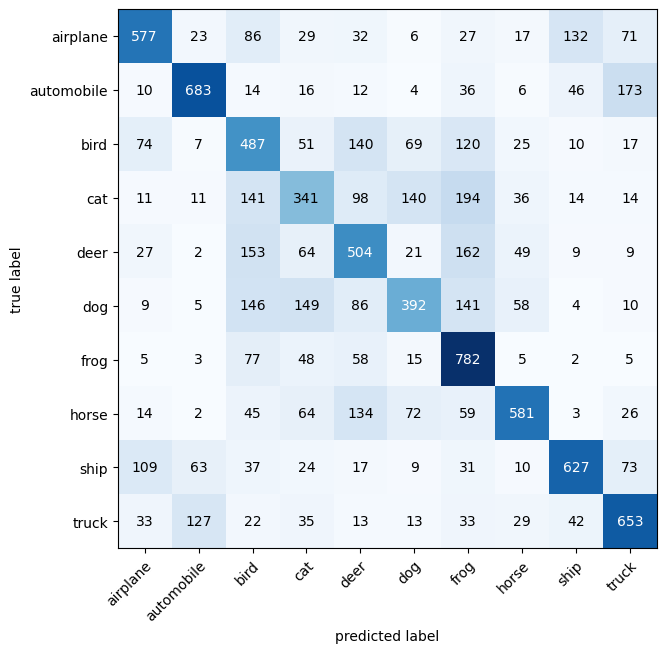

In [150]:
fig, ax = plot_model_confusion_matrix(
    model=model_2,
    dataloader=test_dataloader,
    class_names=class_names,
    test_data=test_data,
    device=device
)


### 📊 Confusion Matrix Insights

The confusion matrix reveals that our model (`CIFAR10ModelV2`) performs well on some classes (e.g., **frog**, **ship**) but struggles with others, particularly:

- **Cat vs. Dog**: Frequent mutual misclassification due to similar visual features.
- **Automobile vs. Truck**: Logical confusion between vehicle classes.
- **Airplane vs. Bird/Ship**: Misclassifications likely caused by shape or background similarities.

These patterns highlight the limitations of our current model, especially in handling **fine-grained visual differences** in low-resolution images.

---

### 🔧 Next Steps

To further improve our model’s performance, we can explore:

- 🌀 **Data Augmentation** (e.g., flips, crops, color jitter) to boost generalization
- 🧱 **Batch Normalization** and **Dropout** for regularization
- 🔁 **Deeper CNN** architecture with more conv blocks
- 🧠 **Transfer Learning** using pretrained models like ResNet or MobileNet

Let's pick one and continue improving!


## 11. Let's Improve

#### What can we do Now ? 
**1. Train for little longer ????**

**Let's train model_2 for 20 epochs with learning rate = `0.01` and see if that improve the performance or not**

In [158]:
# Let's reinstantiate our model_2 # name it model_3
#torch.manual_seed(42)
model_3 = CIFAR10ModelV2(input_shape=3,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(), 
                            lr=0.01)

torch.manual_seed(42)

train_time_start_on_gpu = timer()

# Set epochs
epochs = 20

# Create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(model=model_3, 
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_3,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_3 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 2.30291 | Train acc: 9.75%
Test loss: 2.30253 | Test acc: 9.98%

Epoch: 1
--------
Train Loss: 2.30251 | Train acc: 10.29%
Test loss: 2.30190 | Test acc: 10.64%

Epoch: 2
--------
Train Loss: 2.21611 | Train acc: 17.14%
Test loss: 2.00721 | Test acc: 26.73%

Epoch: 3
--------
Train Loss: 1.96827 | Train acc: 28.50%
Test loss: 1.91704 | Test acc: 29.73%

Epoch: 4
--------
Train Loss: 1.88256 | Train acc: 32.23%
Test loss: 1.96741 | Test acc: 30.47%

Epoch: 5
--------
Train Loss: 1.74062 | Train acc: 38.38%
Test loss: 1.63559 | Test acc: 41.65%

Epoch: 6
--------
Train Loss: 1.59007 | Train acc: 43.99%
Test loss: 1.54787 | Test acc: 45.04%

Epoch: 7
--------
Train Loss: 1.47166 | Train acc: 48.16%
Test loss: 1.44095 | Test acc: 48.73%

Epoch: 8
--------
Train Loss: 1.40555 | Train acc: 50.48%
Test loss: 1.39455 | Test acc: 50.75%

Epoch: 9
--------
Train Loss: 1.35262 | Train acc: 52.44%
Test loss: 1.34511 | Test acc: 52.83%

Epoch: 10
--------
Train Loss: 1

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

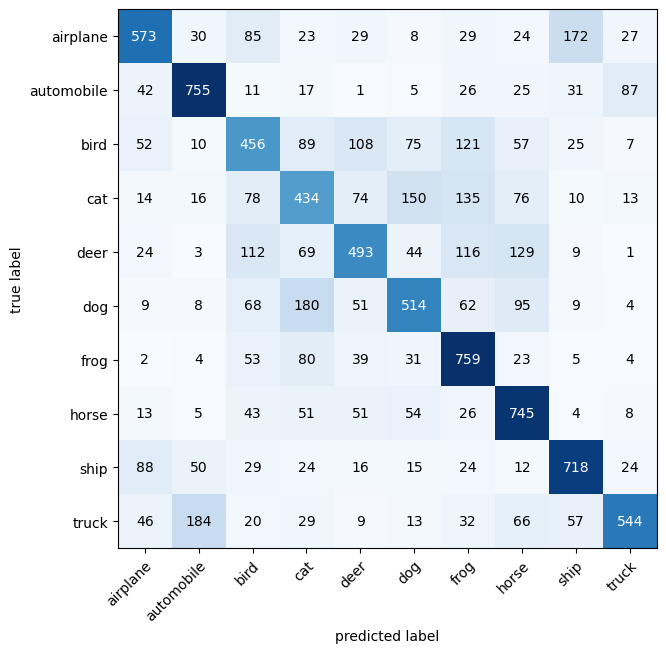

In [159]:
fig, ax = plot_model_confusion_matrix(
    model=model_3,
    dataloader=test_dataloader,
    class_names=class_names,
    test_data=test_data,
    device=device
)


In [161]:
# Get model_3 results
model_3_results = eval_model(
    model=model_3,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_3_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CIFAR10ModelV2',
 'model_loss': 1.1403076648712158,
 'model_acc': 59.91413738019169}

#### 🚀 Improved Model — `CIFAR10ModelV2`

After training `CIFAR10ModelV2` (TinyVGG) for **20 epochs** with a **lower learning rate (0.01)**, we achieved:

- **Loss:** 1.14  
- **Accuracy:** 59.91%

This is a solid improvement over the previous run (5 epochs, lr=0.1), showing the benefits of **longer training** and a **more stable learning rate**.



**2: Let's Use Data Augmentation Technique Will it work???**

In [163]:
# let's define the augmentation
from torchvision import transforms

# Training transform with augmentation
train_transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(size=32, padding=4),
    transforms.ToTensor()
])


train_data = datasets.CIFAR10(root="data",
                     train=True,
                     download=True,
                     transform=train_transform_augmented)

# No changes in test_data for fair evaluation

test_data = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
    
)


# Setup the batchsize hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)





Files already downloaded and verified
Files already downloaded and verified


In [164]:
# Let's reinstantiate our model_2 # name it model_4
#torch.manual_seed(42)
model_4 = CIFAR10ModelV2(input_shape=3,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.01)

torch.manual_seed(42)

train_time_start_on_gpu = timer()

# Set epochs
epochs = 20

# Create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(model=model_4, 
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_4,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_4 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 2.30251 | Train acc: 10.21%
Test loss: 2.30153 | Test acc: 10.09%

Epoch: 1
--------
Train Loss: 2.21891 | Train acc: 17.76%
Test loss: 2.00461 | Test acc: 26.63%

Epoch: 2
--------
Train Loss: 2.01234 | Train acc: 25.89%
Test loss: 1.93249 | Test acc: 30.68%

Epoch: 3
--------
Train Loss: 1.93530 | Train acc: 28.96%
Test loss: 1.83163 | Test acc: 33.65%

Epoch: 4
--------
Train Loss: 1.82752 | Train acc: 33.34%
Test loss: 1.77567 | Test acc: 37.48%

Epoch: 5
--------
Train Loss: 1.72975 | Train acc: 37.15%
Test loss: 1.76958 | Test acc: 38.15%

Epoch: 6
--------
Train Loss: 1.65645 | Train acc: 39.56%
Test loss: 1.56634 | Test acc: 43.25%

Epoch: 7
--------
Train Loss: 1.60193 | Train acc: 41.57%
Test loss: 1.50116 | Test acc: 45.99%

Epoch: 8
--------
Train Loss: 1.56788 | Train acc: 42.81%
Test loss: 1.50482 | Test acc: 46.31%

Epoch: 9
--------
Train Loss: 1.52849 | Train acc: 44.31%
Test loss: 1.47479 | Test acc: 46.89%

Epoch: 10
--------
Train Loss:

**No Performance doesn't increase at all.**

### What can we do next???

**3. let's try different ranges of learning rate and whatever drops the loss faster we will train for 20 epochs with that learning rate.**.

In [166]:

# Learning rates to test
learning_rates = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1]

# Epochs for quick testing
epochs = 3

# Store results
lr_results = {}

for lr in learning_rates:
    print(f"\n🔁 Training with learning rate: {lr}\n{'-'*40}")
    
    # Instantiate a new model for each learning rate
    model_5 = CIFAR10ModelV2(input_shape=3,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)
    
    # Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model_5.parameters(), lr=lr)
    
    # Set seed for reproducibility
    torch.manual_seed(42)
    
    # Track training time
    train_time_start = timer()

    # Train for 3 epochs
    for epoch in tqdm(range(epochs), desc=f"Training @ lr={lr}"):
        print(f"Epoch {epoch}\n--------")
        train_step(model=model_5, 
                   data_loader=train_dataloader,
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   accuracy_fn=accuracy_fn,
                   device=device)
        
        test_step(model=model_5,
                    data_loader=test_dataloader,
                    loss_fn=loss_fn,
                    accuracy_fn=accuracy_fn,
                    device=device)
    
    train_time_end = timer()



🔁 Training with learning rate: 0.001
----------------------------------------


Training @ lr=0.001:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
--------
Train Loss: 2.30000 | Train acc: 11.58%
Test loss: 2.29696 | Test acc: 11.06%

Epoch 1
--------
Train Loss: 2.29164 | Train acc: 11.92%
Test loss: 2.28063 | Test acc: 12.51%

Epoch 2
--------
Train Loss: 2.26201 | Train acc: 13.46%
Test loss: 2.22587 | Test acc: 17.60%


🔁 Training with learning rate: 0.003
----------------------------------------


Training @ lr=0.003:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
--------
Train Loss: 2.30247 | Train acc: 10.17%
Test loss: 2.30192 | Test acc: 11.91%

Epoch 1
--------
Train Loss: 2.30146 | Train acc: 14.01%
Test loss: 2.30014 | Test acc: 17.41%

Epoch 2
--------
Train Loss: 2.29614 | Train acc: 17.16%
Test loss: 2.28250 | Test acc: 20.47%


🔁 Training with learning rate: 0.01
----------------------------------------


Training @ lr=0.01:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
--------
Train Loss: 2.29711 | Train acc: 13.49%
Test loss: 2.23752 | Test acc: 18.38%

Epoch 1
--------
Train Loss: 2.05411 | Train acc: 25.00%
Test loss: 1.96145 | Test acc: 28.91%

Epoch 2
--------
Train Loss: 1.98507 | Train acc: 27.50%
Test loss: 1.88654 | Test acc: 31.77%


🔁 Training with learning rate: 0.03
----------------------------------------


Training @ lr=0.03:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
--------
Train Loss: 2.14088 | Train acc: 20.31%
Test loss: 2.04275 | Test acc: 24.48%

Epoch 1
--------
Train Loss: 1.89626 | Train acc: 30.92%
Test loss: 1.65534 | Test acc: 40.20%

Epoch 2
--------
Train Loss: 1.67392 | Train acc: 39.14%
Test loss: 1.49087 | Test acc: 45.86%


🔁 Training with learning rate: 0.1
----------------------------------------


Training @ lr=0.1:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
--------
Train Loss: 2.04662 | Train acc: 24.68%
Test loss: 1.94054 | Test acc: 31.30%

Epoch 1
--------
Train Loss: 1.70117 | Train acc: 37.85%
Test loss: 1.64057 | Test acc: 40.76%

Epoch 2
--------
Train Loss: 1.57463 | Train acc: 43.06%
Test loss: 1.41545 | Test acc: 48.96%



**So lr = 0.1 works best in this case but we have tried 0.1 before let's see if it will work again.**

In [167]:

epochs = 10

# Instantiate a new model for each learning rate
model_5 = CIFAR10ModelV2(input_shape=3,
                         hidden_units=10,
                         output_shape=len(class_names)).to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_5.parameters(), lr=0.1)

# Set seed for reproducibility
torch.manual_seed(42)

# Track training time
train_time_start = timer()

# Train for 3 epochs
for epoch in tqdm(range(epochs), desc=f"Training @ lr={lr}"):
    print(f"Epoch {epoch}\n--------")
    train_step(model=model_5, 
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_5,
                data_loader=test_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                device=device)
    
train_time_end = timer()


Training @ lr=0.1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
--------
Train Loss: 2.13512 | Train acc: 21.16%
Test loss: 1.95043 | Test acc: 29.76%

Epoch 1
--------
Train Loss: 1.79227 | Train acc: 34.57%
Test loss: 1.71002 | Test acc: 37.41%

Epoch 2
--------
Train Loss: 1.61010 | Train acc: 41.73%
Test loss: 1.55687 | Test acc: 45.08%

Epoch 3
--------
Train Loss: 1.53547 | Train acc: 44.54%
Test loss: 1.45018 | Test acc: 47.25%

Epoch 4
--------
Train Loss: 1.47517 | Train acc: 46.90%
Test loss: 1.33994 | Test acc: 52.39%

Epoch 5
--------
Train Loss: 1.43450 | Train acc: 48.42%
Test loss: 1.75109 | Test acc: 44.60%

Epoch 6
--------
Train Loss: 1.40138 | Train acc: 49.65%
Test loss: 1.44209 | Test acc: 48.27%

Epoch 7
--------
Train Loss: 1.38068 | Train acc: 50.54%
Test loss: 1.26777 | Test acc: 54.92%

Epoch 8
--------
Train Loss: 1.36945 | Train acc: 51.15%
Test loss: 1.30595 | Test acc: 53.97%

Epoch 9
--------
Train Loss: 1.35442 | Train acc: 52.02%
Test loss: 1.26745 | Test acc: 55.18%



**Still can't improve the performance....**

**4. Let's try different learning algorithm what about SGD with momentum ??**

In [170]:
# Let's reinstantiate our model_2 # name it model_6  -> SGD with momentum
torch.manual_seed(42)
model_6 = CIFAR10ModelV2(input_shape=3,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_6.parameters(), 
                            lr=0.01, momentum=0.90)

torch.manual_seed(42)

train_time_start_on_gpu = timer()

# Set epochs
epochs = 4

# Create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(model=model_6, 
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_6,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_6 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 2.13062 | Train acc: 19.98%
Test loss: 1.96586 | Test acc: 28.14%

Epoch: 1
--------
Train Loss: 1.73762 | Train acc: 36.31%
Test loss: 1.52105 | Test acc: 43.47%

Epoch: 2
--------
Train Loss: 1.59673 | Train acc: 41.46%
Test loss: 1.50445 | Test acc: 46.54%

Epoch: 3
--------
Train Loss: 1.51562 | Train acc: 44.93%
Test loss: 1.35382 | Test acc: 51.40%

Train time on cuda: 87.244 seconds


**Still Can't Improve the performance**

**5. Let's Try Adam Optimizer**

In [175]:
# Let's reinstantiate our model_2 # name it model_7  -> Adam
torch.manual_seed(42)
model_7 = CIFAR10ModelV2(input_shape=3,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_7.parameters(), 
                            lr=0.001)

torch.manual_seed(42)

train_time_start_on_gpu = timer()

# Set epochs
epochs = 15

# Create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(model=model_7, 
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_7,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_7 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 1.80643 | Train acc: 33.95%
Test loss: 1.57190 | Test acc: 43.80%

Epoch: 1
--------
Train Loss: 1.57557 | Train acc: 42.88%
Test loss: 1.43941 | Test acc: 48.45%

Epoch: 2
--------
Train Loss: 1.50739 | Train acc: 45.41%
Test loss: 1.36977 | Test acc: 50.23%

Epoch: 3
--------
Train Loss: 1.44345 | Train acc: 47.89%
Test loss: 1.29857 | Test acc: 53.42%

Epoch: 4
--------
Train Loss: 1.37950 | Train acc: 50.32%
Test loss: 1.25148 | Test acc: 55.39%

Epoch: 5
--------
Train Loss: 1.32578 | Train acc: 52.76%
Test loss: 1.20353 | Test acc: 57.31%

Epoch: 6
--------
Train Loss: 1.28912 | Train acc: 54.12%
Test loss: 1.17690 | Test acc: 58.84%

Epoch: 7
--------
Train Loss: 1.25835 | Train acc: 55.27%
Test loss: 1.13895 | Test acc: 59.61%

Epoch: 8
--------
Train Loss: 1.23096 | Train acc: 56.06%
Test loss: 1.10597 | Test acc: 60.46%

Epoch: 9
--------
Train Loss: 1.20842 | Train acc: 56.84%
Test loss: 1.14651 | Test acc: 59.91%

Epoch: 10
--------
Train Loss:

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

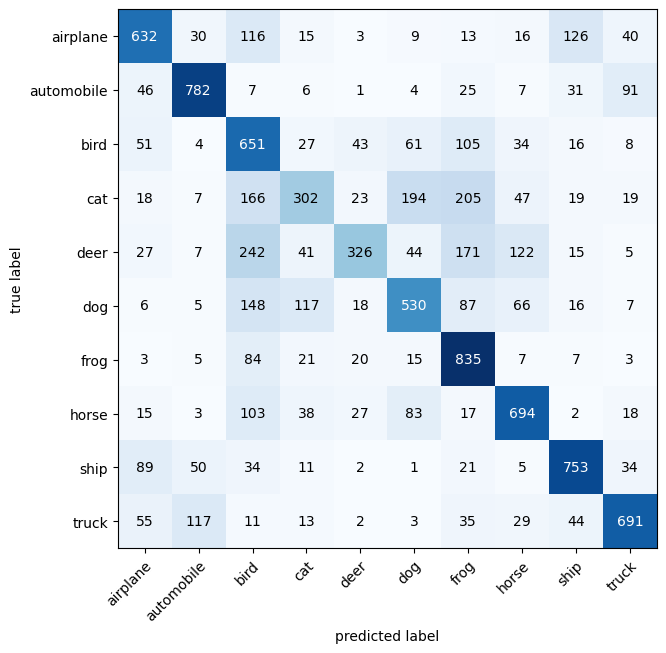

In [176]:
fig, ax = plot_model_confusion_matrix(
    model=model_7,
    dataloader=test_dataloader,
    class_names=class_names,
    test_data=test_data,
    device=device
)


**Improved performance by 2 % but not enough**

**6. Let's build deeper model**

### 12. Model 3: Deeper Convolutional Neural Network

In [177]:
import torch
from torch import nn

class CIFAR10ModelV3(nn.Module):
    """
    A deeper CNN for CIFAR-10 with Conv-BatchNorm-Dropout blocks.
    Improves on TinyVGG by adding more filters, normalization, and regularization.
    """
    def __init__(self, num_classes: int = 10):
        super(CIFAR10ModelV3, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [183]:
# Model 8
torch.manual_seed(42)
model_8 = CIFAR10ModelV3().to(device)
model_8

CIFAR10ModelV3(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.3, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Fl

In [184]:

# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_8.parameters(), 
                            lr=0.001)

torch.manual_seed(42)

train_time_start_on_gpu = timer()

# Set epochs
epochs = 10
# Create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(model=model_8, 
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_8,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_8 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 1.60468 | Train acc: 40.34%
Test loss: 1.38829 | Test acc: 48.33%

Epoch: 1
--------
Train Loss: 1.31335 | Train acc: 52.70%
Test loss: 1.28501 | Test acc: 52.73%

Epoch: 2
--------
Train Loss: 1.18265 | Train acc: 57.54%
Test loss: 1.02080 | Test acc: 66.42%

Epoch: 3
--------
Train Loss: 1.09829 | Train acc: 61.02%
Test loss: 1.23661 | Test acc: 56.75%

Epoch: 4
--------
Train Loss: 1.02941 | Train acc: 63.75%
Test loss: 0.93223 | Test acc: 67.28%

Epoch: 5
--------
Train Loss: 0.98412 | Train acc: 65.63%
Test loss: 1.01333 | Test acc: 63.78%

Epoch: 6
--------
Train Loss: 0.93835 | Train acc: 67.39%
Test loss: 0.92014 | Test acc: 67.47%

Epoch: 7
--------
Train Loss: 0.90674 | Train acc: 68.67%
Test loss: 0.80194 | Test acc: 72.00%

Epoch: 8
--------
Train Loss: 0.88177 | Train acc: 69.61%
Test loss: 0.74490 | Test acc: 75.72%

Epoch: 9
--------
Train Loss: 0.84669 | Train acc: 70.80%
Test loss: 0.80927 | Test acc: 71.59%

Train time on cuda: 242.269 se

**Wohooow 71% on test set**

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

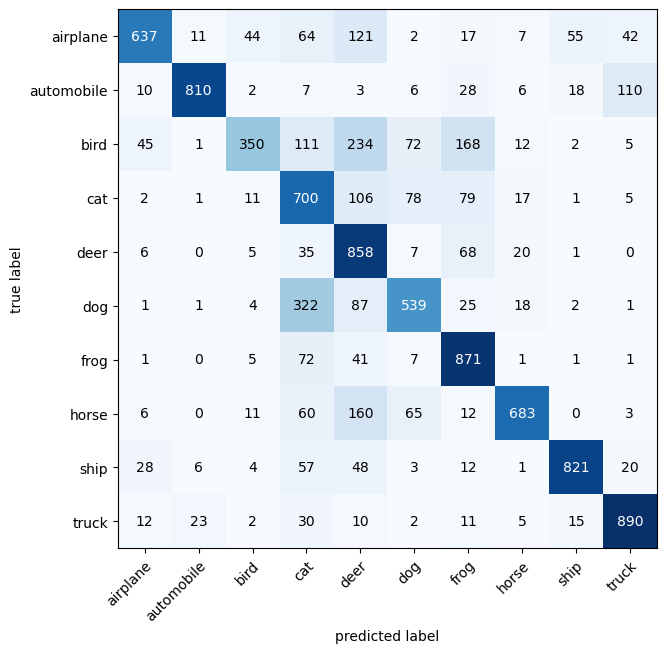

In [185]:
fig, ax = plot_model_confusion_matrix(
    model=model_8,
    dataloader=test_dataloader,
    class_names=class_names,
    test_data=test_data,
    device=device
)


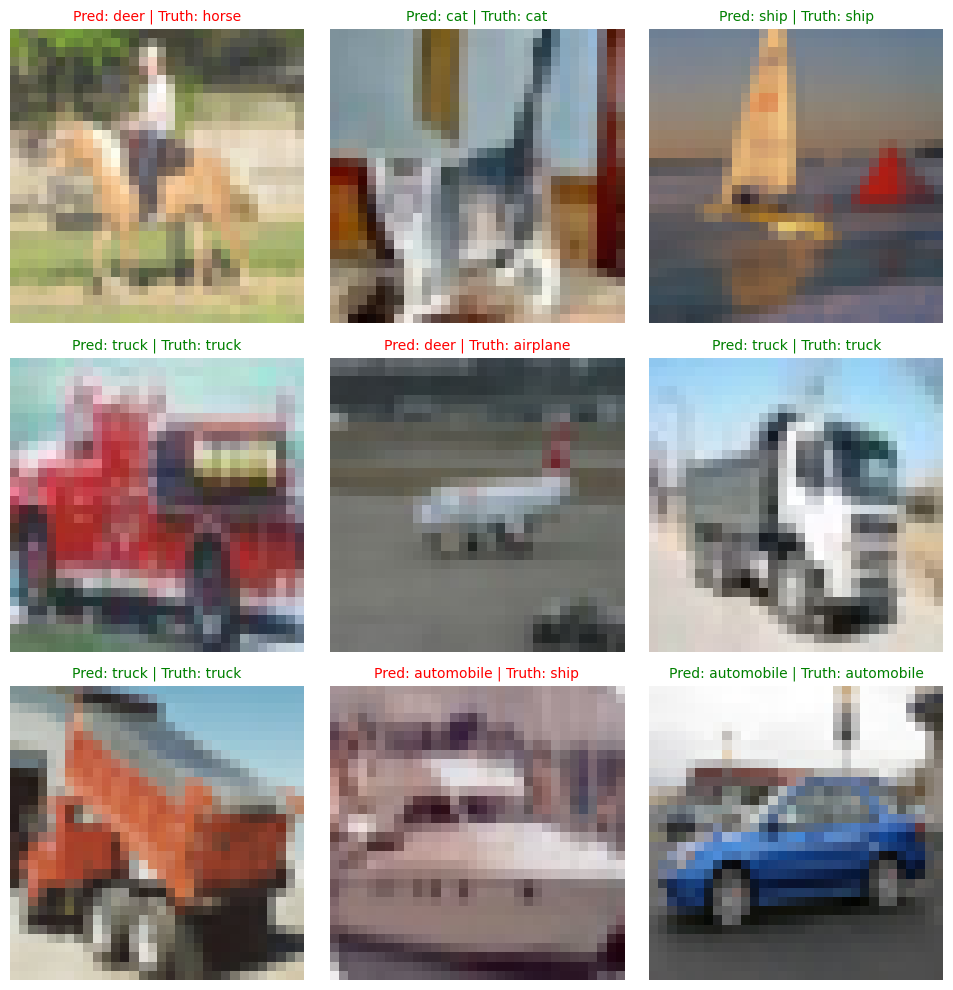

In [189]:
# Plot predictions
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs = make_predictions(model=model_8,
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
# Plot the predictions
plt.figure(figsize=(10, 10))
nrows = 3
ncols = 3 
for i, sample in enumerate(test_samples):
    # Create suplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0))

    # Find the prediction (in text form eg. Sandal)
    pred_label = class_names[pred_classes[i]]

    # Find the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'

    # Check for equality b/w pred and truth and change color of title text 
    if truth_label == pred_label:
        plt.title(title_text , fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis('off')
    plt.tight_layout()


In [190]:
model_8_results = eval_model(
    model=model_8,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_8_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CIFAR10ModelV3',
 'model_loss': 0.8092718720436096,
 'model_acc': 71.58546325878594}

### 🧠 Model V3 Results — `CIFAR10ModelV3`

We introduced a deeper CNN architecture with:
- ✅ Three convolutional blocks
- ✅ Batch Normalization for stable training
- ✅ Dropout for regularization

After training for 10 epochs, `CIFAR10ModelV3` achieved:

- **Loss:** 0.81  
- **Accuracy:** 71.59%

This is a **significant improvement** over previous models, showing that **deeper CNNs with normalization and regularization** can extract more meaningful features and generalize better on the CIFAR-10 dataset.


## 13. Model 4 - More deeper network

In [191]:

class CIFAR10ModelV4(nn.Module):
    """
    Deeper CNN with 4 Conv blocks, BatchNorm, and Dropout.
    Inspired by classic CNN stacks for CIFAR-10.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [192]:
# Model 9

torch.manual_seed(42)
model_9 = CIFAR10ModelV4().to(device)
model_9

CIFAR10ModelV4(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, in

In [196]:

# Setup loss function/eval metrics/optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_9.parameters(), 
                            lr=0.001)

torch.manual_seed(42)

train_time_start_on_gpu = timer()

# Set epochs
epochs = 15
# Create an optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(model=model_9, 
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    test_step(model=model_9,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_9 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 0.49228 | Train acc: 83.44%
Test loss: 0.44659 | Test acc: 85.01%

Epoch: 1
--------
Train Loss: 0.47141 | Train acc: 84.02%
Test loss: 0.45131 | Test acc: 85.15%

Epoch: 2
--------
Train Loss: 0.45993 | Train acc: 84.29%
Test loss: 0.44943 | Test acc: 85.03%

Epoch: 3
--------
Train Loss: 0.43649 | Train acc: 85.31%
Test loss: 0.43937 | Test acc: 85.53%

Epoch: 4
--------
Train Loss: 0.43728 | Train acc: 85.27%
Test loss: 0.41325 | Test acc: 86.15%

Epoch: 5
--------
Train Loss: 0.42666 | Train acc: 85.59%
Test loss: 0.42559 | Test acc: 85.98%

Epoch: 6
--------
Train Loss: 0.41381 | Train acc: 85.79%
Test loss: 0.41190 | Test acc: 86.26%

Epoch: 7
--------
Train Loss: 0.40123 | Train acc: 86.27%
Test loss: 0.45706 | Test acc: 84.94%

Epoch: 8
--------
Train Loss: 0.39374 | Train acc: 86.46%
Test loss: 0.43912 | Test acc: 86.57%

Epoch: 9
--------
Train Loss: 0.38464 | Train acc: 87.08%
Test loss: 0.41808 | Test acc: 85.98%

Epoch: 10
--------
Train Loss:

**Wow 86% Accuracy**

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

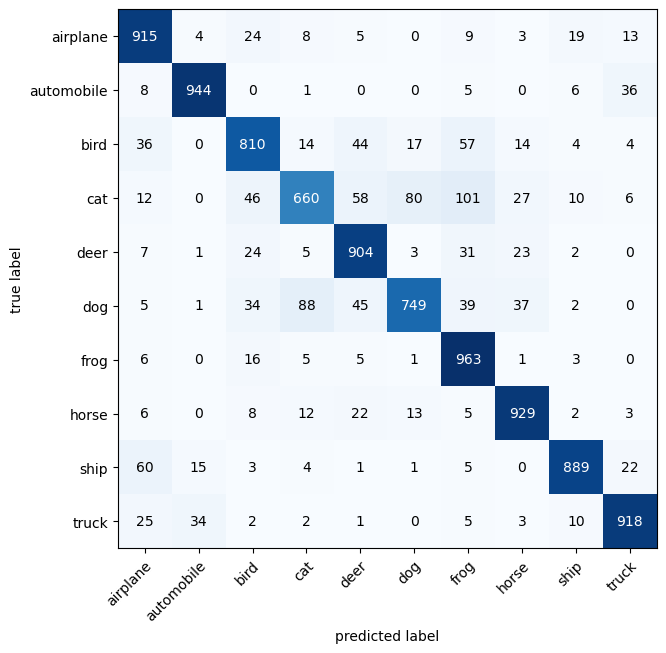

In [197]:
fig, ax = plot_model_confusion_matrix(
    model=model_9,
    dataloader=test_dataloader,
    class_names=class_names,
    test_data=test_data,
    device=device
)


In [198]:
model_9_results = eval_model(
    model=model_9,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_9_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CIFAR10ModelV4',
 'model_loss': 0.4113442897796631,
 'model_acc': 86.80111821086263}

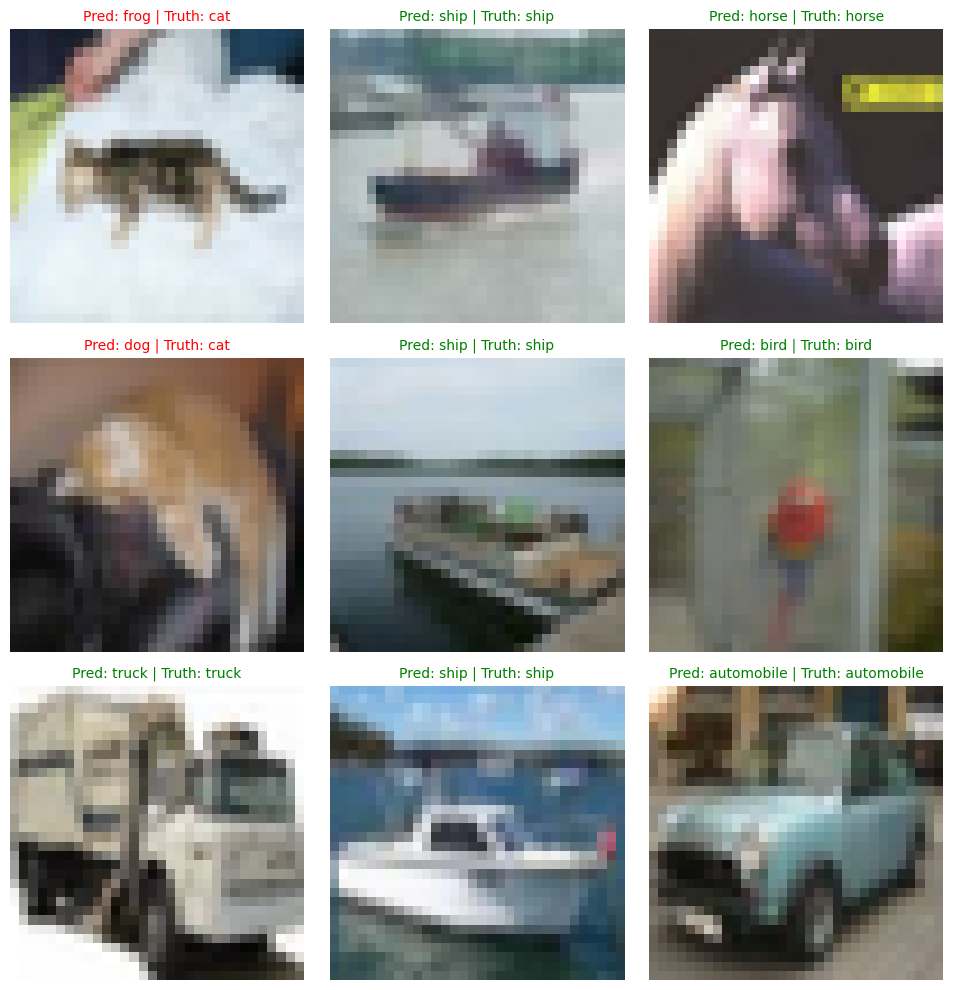

In [199]:
# Plot predictions
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs = make_predictions(model=model_9,
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
# Plot the predictions
plt.figure(figsize=(10, 10))
nrows = 3
ncols = 3 
for i, sample in enumerate(test_samples):
    # Create suplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.permute(1, 2, 0))

    # Find the prediction (in text form eg. Sandal)
    pred_label = class_names[pred_classes[i]]

    # Find the truth label (in text form)
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'

    # Check for equality b/w pred and truth and change color of title text 
    if truth_label == pred_label:
        plt.title(title_text , fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis('off')
    plt.tight_layout()


## 14: Let's predict on our own image

In [200]:
from PIL import Image

In [201]:
custom_image_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [202]:
def predict_custom_image(image_path, model, class_names, transform, device):
    """
    Predicts the class of a single image using a trained model.
    
    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained PyTorch model.
        class_names (List[str]): List of class labels.
        transform (torchvision.transforms): Transform to apply to image.
        device (torch.device): CPU or GPU.
        
    Returns:
        None (prints and plots result)
    """
    # Load and preprocess
    img = Image.open(image_path).convert("RGB")
    img_transformed = transform(img).unsqueeze(0).to(device)

    # Set model to eval and predict
    model.eval()
    with torch.inference_mode():
        preds = model(img_transformed)
        pred_class = preds.argmax(dim=1).item()
    
    # Show image and prediction
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[pred_class]}")
    plt.axis("off")
    plt.show()


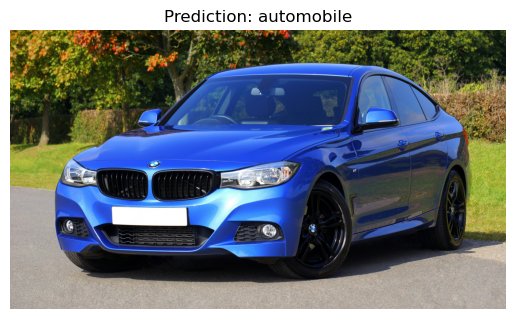

In [204]:
custom_img_path = r"C:\Users\yashs\Downloads\car.jpg"

predict_custom_image(
    image_path=custom_img_path,
    model=model_9,  
    class_names=class_names,
    transform=custom_image_transform,
    device=device
)


## **WOW yes it is an AutoMobile**

#### Let's Try 1 more

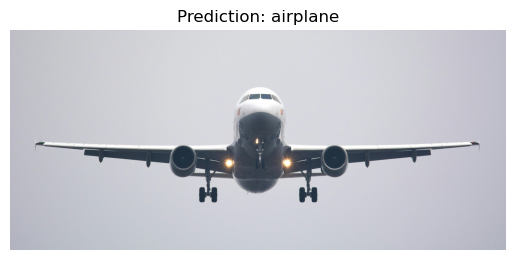

In [205]:
custom_img_path = r"C:\Users\yashs\Downloads\airplane.jpg"

predict_custom_image(
    image_path=custom_img_path,
    model=model_9,  
    class_names=class_names,
    transform=custom_image_transform,
    device=device
)


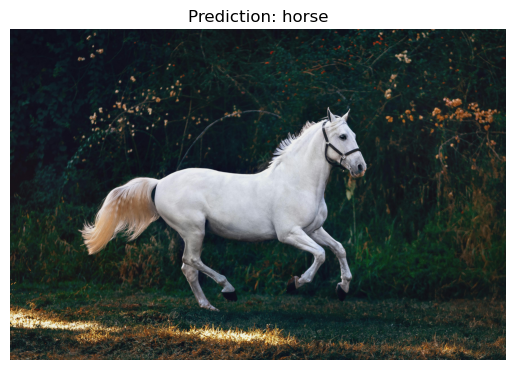

In [206]:
custom_img_path = r"C:\Users\yashs\Downloads\horse.jpg"

predict_custom_image(
    image_path=custom_img_path,
    model=model_9,  
    class_names=class_names,
    transform=custom_image_transform,
    device=device
)


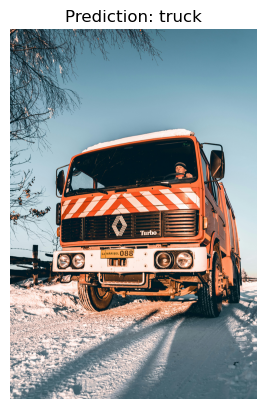

In [208]:
custom_img_path = r"C:\Users\yashs\Downloads\truck.jpg"

predict_custom_image(
    image_path=custom_img_path,
    model=model_9,  # <- your trained model
    class_names=class_names,
    transform=custom_image_transform,
    device=device
)


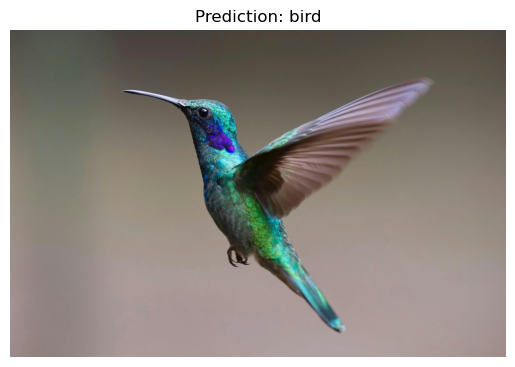

In [209]:
custom_img_path = r"C:\Users\yashs\Downloads\bird.jpg"

predict_custom_image(
    image_path=custom_img_path,
    model=model_9,  # <- your trained model
    class_names=class_names,
    transform=custom_image_transform,
    device=device
)


## 15. Let's Save the model 

In [210]:
from pathlib import Path

In [212]:
# Create model directory path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = 'cifar10_model_9.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict 
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_9.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\cifar10_model_9.pth


In [213]:
!where python

C:\Users\yashs\anaconda3\envs\torch_gpu_env\python.exe
C:\Users\yashs\anaconda3\python.exe
C:\Users\yashs\AppData\Local\Programs\Python\Python313\python.exe
C:\Users\yashs\AppData\Local\Microsoft\WindowsApps\python.exe
